#### Example running SpaFHy with jupyter notebook

In [1]:
from model_driver import driver
from iotools import read_results
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os

os.chdir(r'C:\SpaFHy_v1_Pallas_2D')

# example of calling driver, reading results
outputfile = driver(create_ncf=True, create_spinup=False, folder='testcase_input')
results = read_results(outputfile)

*** Defined soil IDs: {1.0, 2.0, 3.0, 4.0} Used soil IDs: {1.0, 2.0, 4.0}
*** State variables assigned from parameters.py ***
*** Distributed radiation used ***
*** Simulation forced with: testcase_input\forcing\Kenttarova_forcing_era5.csv


C:\SpaFHy_v1_Pallas_2D\canopygrid.py:798: RuntimeWarning: invalid value encountered in arccos
  dl = 2.0*np.arccos(cosZEN - np.sin(LAT)*np.sin(DECL) / (np.cos(LAT)*np.cos(DECL))) / CF / 15.0  # hours


*** Running model ***
*** 2D run
Running timestep:  1
Timestep: 1 iterations 5 0.000954854726899157 -0.0012563934022864487
Running timestep:  2
Timestep: 2 iterations 6 0.0008110106894037017 0.0010201712456137102
Running timestep:  3
Timestep: 3 iterations 9 0.0004080249350977283 0.00012175857551710578
Running timestep:  4
Timestep: 4 iterations 11 0.0005219311898372325 -0.00871780579592496
Running timestep:  5
Timestep: 5 iterations 11 0.0007474217977687658 -0.007854943469055797
Running timestep:  6
Timestep: 6 iterations 13 0.000835226377773779 -0.00967747470406266
Running timestep:  7
Timestep: 7 iterations 16 0.0002697103805644474 -0.0067309186504758145
Running timestep:  8
Timestep: 8 iterations 12 0.00030095007565478227 0.0002772131194888061
Running timestep:  9
Timestep: 9 iterations 14 0.0007205391171964948 -0.009815255130945388
Running timestep:  10
Timestep: 10 iterations 12 0.0006778847360919826 -0.006428218004657538
Running timestep:  11
Timestep: 11 iterations 11 0.0008114

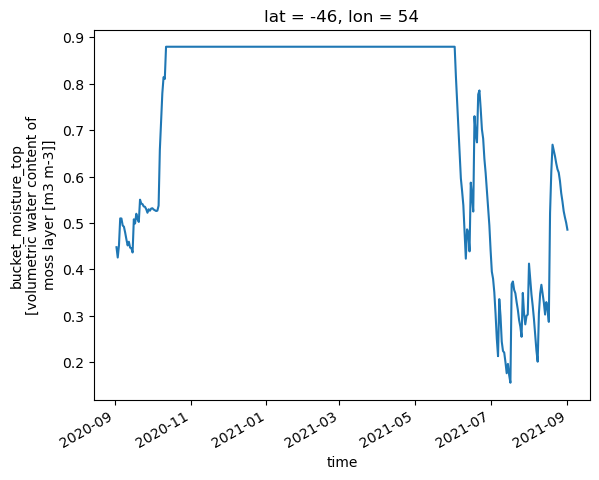

In [21]:
om = [46, 54]   # open mire
#results['bucket_moisture_top'].sel(time='2021-06-17').plot()
results['bucket_moisture_top'][:,om[0], om[1]].plot()
#results['bucket_moisture_root'][:,om[0],om[1]].plot()

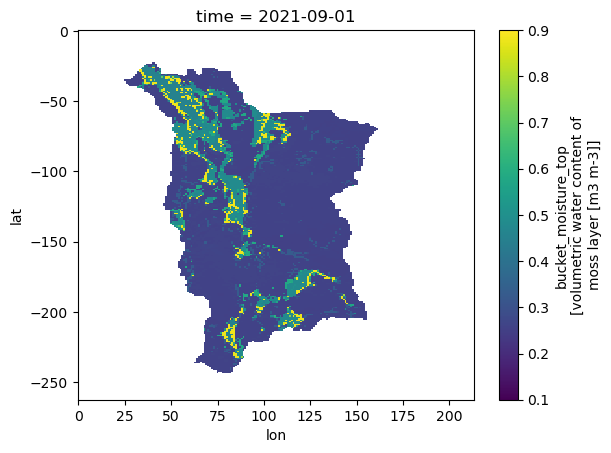

In [4]:
results['bucket_moisture_top'][-1].plot(vmin=0.1, vmax=0.9)

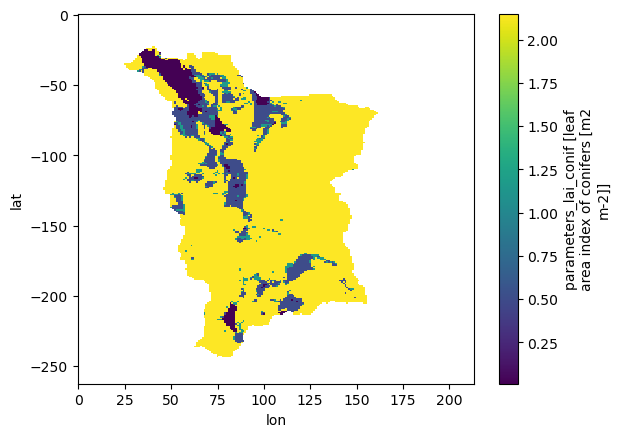

In [5]:
results['parameters_lai_conif'].plot()

In [1]:
xr.open_dataset(r'F:\SpaFHy_2D_2021\res_2d_ave_newnew_23.nc)['parameters_lai_conif'].plot()

SyntaxError: unterminated string literal (detected at line 1) (3974114339.py, line 1)